# Multiple Stripe Analysis (MSA) for Single Degree of Freedom (SDOF) Oscillators

In this method, a single degree of freedom (SDOF) model of each structure is subjected to non-linear time history analysis using a suite of ground motion records scaled to multple stripes of intensity measure. The displacements of the SDOF due to each ground motion record are used as input to determine the distribution of buildings in each damage state for each level of ground motion intensity. A regression algorithm is then applied to derive the fragility model.

The figure below illustrates the results of a Multiple Stripe Analysis, from which the fragility function is built.

<img src="../../../../figures/MSA_example.jpg" width="500" align="middle">

**Note**: To run the code in a cell:

1. Click on the cell to select it.
2. Press `SHIFT+ENTER` on your keyboard or press the play button (<button class='fa fa-play icon-play btn btn-xs btn-default'></button>) in the toolbar above.

In [22]:
import MSA_on_SDOF
from rmtk.vulnerability.common import utils
import numpy as np
%matplotlib inline 

---
### Load capacity curves

In order to use this methodology, it is necessary to provide one (or a group) of capacity curves, defined according to the format described in the [RMTK manual](../../../../rmtk-docs.pdf).

Please provide the location of the file containing the capacity curves using the parameter `capacity_curves_file`.

If the User wants to specify the cyclic hysteretic behaviour of the SDOF system, please input the path of the file where the hysteretic parameters are contained, using the variable `sdof_hysteresis`. The parameters should be defined according to the format described in the [RMTK manual](../../../../rmtk-docs.pdf). If instead default parameters want to be assumed, please set the `sdof_hysteresis` variable to `"Default"`

In [23]:
capacity_curves_file = "../../../../../rmtk_data/capacity_curves_Sd-Sa.csv"
sdof_hysteresis = "Default"
#sdof_hysteresis = "../../../../../rmtk_data/pinching_parameters.csv"

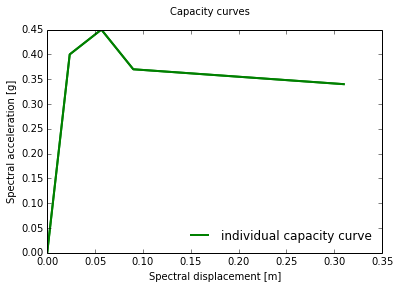

In [24]:
from read_pinching_parameters import read_parameters

capacity_curves = utils.read_capacity_curves(capacity_curves_file)
capacity_curves = utils.check_SDOF_curves(capacity_curves)
utils.plot_capacity_curves(capacity_curves)
hysteresis = read_parameters(sdof_hysteresis)

### Load ground motion records
For what concerns the ground motions to be used in th Multiple Stripe Analysis the following inputs are required:
 1. `gmrs_folder`: path to the folder containing the ground motion records to be used in the analysis. Each accelerogram needs to be in a separate CSV file as described in the [RMTK manual](../../../../rmtk-docs.pdf).
 2. `record_scaled_folder`. In this folder there should be a csv file for each Intensity Measure bin selected for the MSA, containing the names of the records that should be scaled to that IM bin, and the corresponding scaling factors. An example of this type of file is provided in the [RMTK manual](../../../../rmtk-docs.pdf).
 3. `no_bins`: number of Intensity Measure bins.
 4. `no_rec_bin`: number of records per bin

If the user wants to plot acceleration, displacement and velocity response spectra, the function `utils.plot_response_spectra(gmrs, minT, maxT)` should be un-commented. The parameters `minT` and `maxT` are used to define the period bounds when plotting the spectra for the provided ground motion fields.

In [25]:
gmrs_folder = "../../../../../rmtk_data/accelerograms"
minT, maxT = 0.1, 2.0
no_bins = 4
no_rec_bin = 4
record_scaled_folder = "../../../../../rmtk_data/Scaled_trial"

gmrs = utils.read_gmrs(gmrs_folder)
#utils.plot_response_spectra(gmrs, minT, maxT)

### Load damage state thresholds

Please provide the path to your damage model file using the parameter `damage_model_file` in the cell below.

Currently the user can provide `spectral displacement`, `capacity curve dependent` and `interstorey drift` damage model type.
If the damage model type is `interstorey drift` the user has to input interstorey drift values of the MDOF system. The user can then provide the pushover curve in terms of `Vb-dfloor` to be able to convert interstorey drift limit states to roof displacements and spectral displacements of the SDOF system, otherwise a linear relationship is assumed.

In [26]:
damage_model_file = "../../../../../rmtk_data/damage_model_Sd.csv"

damage_model = utils.read_damage_model(damage_model_file)

### Obtain the damage probability matrix

The following parameters need to be defined in the cell below in order to calculate the damage probability matrix:
1. `damping_ratio`: This parameter defines the damping ratio for the structure.
2. `degradation`: This boolean parameter should be set to `True` or `False` to specify whether structural degradation should be considered in the analysis or not.

In [27]:
damping_ratio = 0.05
degradation = False

msa = {}; msa['n. bins']=no_bins; msa['records per bin']=no_rec_bin; msa['input folder']=record_scaled_folder
PDM, Sds, IML_info = MSA_on_SDOF.calculate_fragility(capacity_curves, hysteresis, msa, gmrs, 
                                                      damage_model, damping_ratio, degradation)

100%
records_target1.csv
gmr n. 1 max disp. = 0.0443485 DS = 1
gmr n. 2 max disp. = 0.0443485 DS = 1
gmr n. 3 max disp. = 0.0443485 DS = 1
gmr n. 4 max disp. = 0.0443485 DS = 1
records_target2.csv
gmr n. 5 max disp. = 0.0719205 DS = 2
gmr n. 6 max disp. = 0.0719205 DS = 3
gmr n. 7 max disp. = 0.0719205 DS = 3
gmr n. 8 max disp. = 0.0719205 DS = 2
records_target3.csv
gmr n. 9 max disp. = 0.399065 DS = 4
gmr n. 10 max disp. = 0.399065 DS = 4
gmr n. 11 max disp. = 0.399065 DS = 4
gmr n. 12 max disp. = 0.399065 DS = 4
records_target4.csv
gmr n. 13 max disp. = 0.555058 DS = 4
gmr n. 14 max disp. = 0.555058 DS = 4
gmr n. 15 max disp. = 0.555058 DS = 4
gmr n. 16 max disp. = 0.555058 DS = 4


### Fit lognormal CDF fragility curves

The following parameters need to be defined in the cell below in order to fit lognormal CDF fragility curves to the damage probability matrix obtained above:
1. `IMT`: This parameter specifies the intensity measure type to be used. Currently supported options are `"PGA"`, `"Sa"`,`"Sd"` and `"HI"` (Housner Intensity).
2. `period`: This parameter defines the period for which a spectral intensity measure should be computed. If Housner Intensity is selected as intensity measure a range of periods should be defined instead (for example `T=np.arange(0.3,3.61,0.01)`).
3. `regression_method`: This parameter defines the regression method to be used for estimating the parameters of the fragility functions. The valid options are `"least squares"` and `"max likelihood"`.

In [11]:
import MSA_post_processing

IMT = "Sa"
T = 0.466
regression_method = "max likelihood"

fragility_model = MSA_post_processing.calculate_fragility_model(PDM,gmrs,IML_info,IMT,msa,damage_model,
                                                                        T,damping_ratio, regression_method)

Optimization terminated successfully.
         Current function value: 10.774712
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: 15.156088
         Iterations: 31
         Function evaluations: 60
Optimization terminated successfully.
         Current function value: 14.470797
         Iterations: 49
         Function evaluations: 92


### Plot fragility functions

The following parameters need to be defined in the cell below in order to plot the lognormal CDF fragility curves obtained above:
* `minIML` and `maxIML`: These parameters define the limits of the intensity measure level for plotting the functions

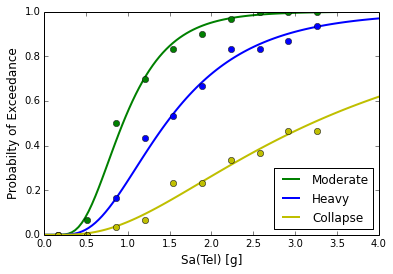

In [12]:
minIML, maxIML = 0.01, 4
utils.plot_fragility_model(fragility_model, minIML, maxIML)


### Save fragility functions
 
The derived parametric fragility functions can be saved to a file in either CSV format or in the NRML format that is used by all OpenQuake input models. The following parameters need to be defined in the cell below in order to save the lognormal CDF fragility curves obtained above:
 1. `taxonomy`: This parameter specifies a taxonomy string for the the fragility functions.
 2. `minIML` and `maxIML`: These parameters define the bounds of applicability of the functions.
 3. `output_type`: This parameter specifies the file format to be used for saving the functions. Currently, the formats supported are "csv" and "nrml".

In [13]:
taxonomy = "RC"
minIML, maxIML = 0.01, 3.00
output_type = "csv"
output_path = "../../../../../phd_thesis/"

In [14]:
utils.save_mean_fragility(taxonomy, fragility_model, minIML, maxIML, output_type, output_path)

### Obtain vulnerability function

A vulnerability model can be derived by combining the set of fragility functions obtained above with a consequence model. In this process, the fractions of buildings in each damage state are multiplied by the associated damage ratio from the consequence model, in order to obtain a distribution of loss ratio for each intensity measure level. 

The following parameters need to be defined in the cell below in order to calculate vulnerability functions using the above derived fragility functions:
1. `cons_model_file`: This parameter specifies the path of the consequence model file.
2. `imls`: This parameter specifies a list of intensity measure levels in increasing order at which the distribution of loss ratios are required to be calculated.
3. `distribution_type`: This parameter specifies the type of distribution to be used for calculating the vulnerability function. The distribution types currently supported are "lognormal", "beta", and "PMF".

In [17]:
cons_model_file = "../../../../../rmtk_data/cons_model.csv"
imls = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 
        0.60, 0.70, 0.80, 0.90, 1.00, 1.20, 1.40, 1.60, 1.80, 2.00, 
        2.20, 2.40, 2.60, 2.80, 3.00, 3.20, 3.40, 3.60, 3.80, 4.00]
distribution_type = "lognormal"

In [18]:
cons_model = utils.read_consequence_model(cons_model_file)
vulnerability_model = utils.convert_fragility_vulnerability(fragility_model, cons_model, 
                                                            imls, distribution_type)

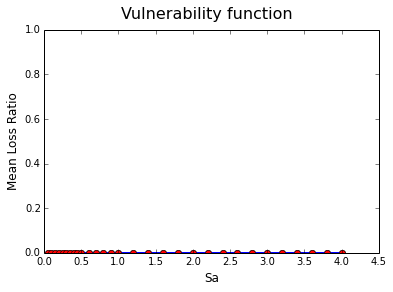

In [19]:
utils.plot_vulnerability_model(vulnerability_model)

### Save vulnerability function

The derived parametric or nonparametric vulnerability function can be saved to a file in either CSV format or in the NRML format that is used by all OpenQuake input models. The following parameters need to be defined in the cell below in order to save the lognormal CDF fragility curves obtained above:
1. `taxonomy`: This parameter specifies a taxonomy string for the the fragility functions.
3. `output_type`: This parameter specifies the file format to be used for saving the functions. Currently, the formats supported are "csv" and "nrml".

In [20]:
taxonomy = "RC"
output_type = "csv"
output_path = "../../../../../rmtk_data/output/"

In [21]:
utils.save_vulnerability(taxonomy, vulnerability_model, output_type, output_path)